### Исправь подьменую силу (множитель *2 по углу)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import os
import warnings
warnings.filterwarnings("ignore")

### Глобальные переменные

In [2]:
gamma = 1.4
rho_inf = 1.2255
p_inf = 101330
a_inf = np.sqrt(gamma * p_inf / rho_inf)
Mach_inf = 1.5
V_inf = Mach_inf * a_inf

### Функция поверхности тела $r_b(z)$

In [53]:
def r_b(z):
    # return np.ones_like(z)
    # z0 = 1 / np.tan(np.pi / 12)
    # return 1 * (z / 20.0 - z0 / 20.0 + 1)
    # return np.tan(np.pi / 12.0) * (z / 20.0 + 0.95)
    return np.tan(np.pi/12) * np.sqrt(2*z - 1)
    # return np.tan(np.pi/12) * z

### Загрузка начальных данных (задача о конусе)

In [4]:
# φ и p(φ), ρ(φ), V_R(φ), V_θ(φ)
data_p   = np.loadtxt('p_init.txt')            # shape (L,2): [φ, p]
data_rho = np.loadtxt('rho_init.txt')          # shape (L,2): [φ, ρ]
data_vr_vtheta = np.loadtxt('VR_Vtheta_init.txt')

phi_cone, p_cone = data_p[::-1,0], data_p[::-1,1]
_, rho_cone = data_rho[::-1,0], data_rho[::-1,1]
_, VR_cone, Vtheta_cone = data_vr_vtheta[::-1,0], data_vr_vtheta[::-1,1], data_vr_vtheta[::-1,2]

### Загрузка данных (основная задача)

In [5]:
zs = np.loadtxt('z_out.txt')
rs = np.loadtxt('r_s_out.txt')
Fy = np.loadtxt('Fy_out.txt')
Mz = np.loadtxt('Mz_out.txt')
K, M = rs.shape
rho = np.loadtxt('rho_out.txt')
assert rho.shape[0] % K == 0
N = rho.shape[0] // K
rho = rho.reshape(K, N, M)
p = np.loadtxt('p_out.txt').reshape(K, N, M)
u = np.loadtxt('u_out.txt').reshape(K, N, M)
v = np.loadtxt('v_out.txt').reshape(K, N, M)
w = np.loadtxt('w_out.txt').reshape(K, N, M)
z0 = zs[0]
print('Количество узлов:')
print(f'z: {K}, r: {N}, theta: {M}')

Количество узлов:
z: 301, r: 400, theta: 1200


### Отрисовка исходной области (xi, theta)

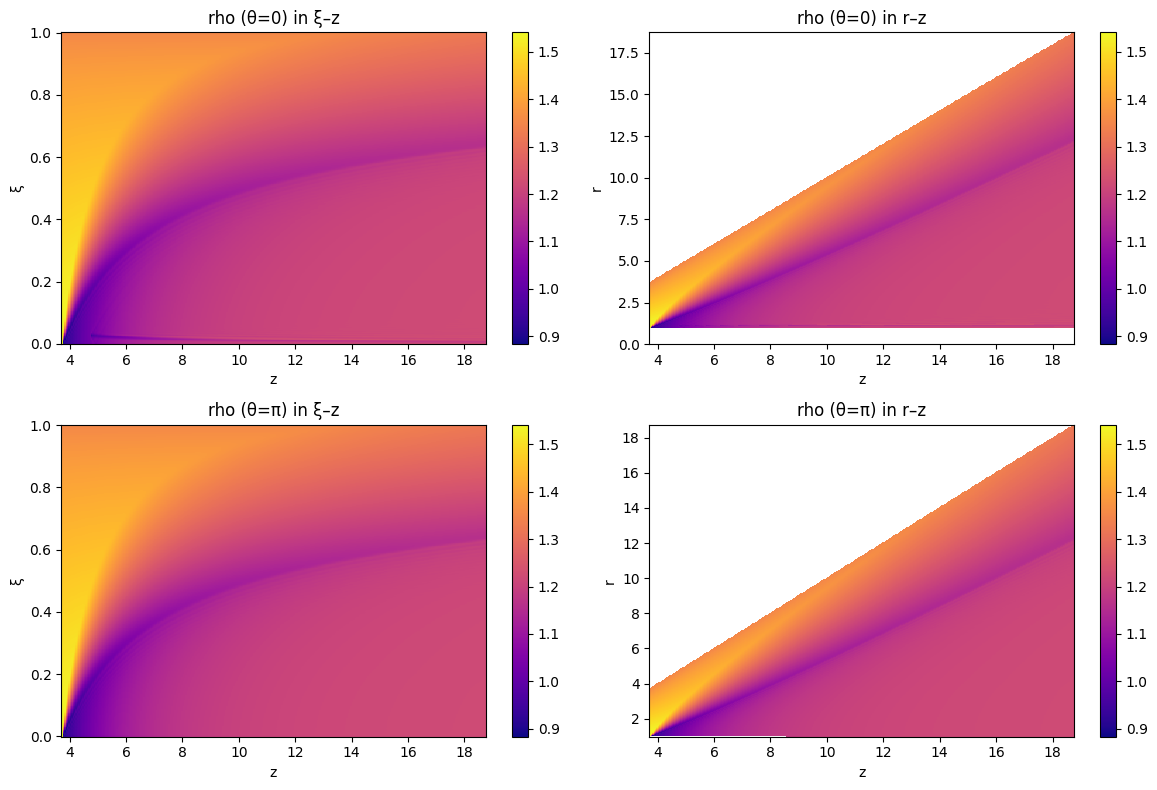

In [6]:
# размеры
# K, N, M = rho.shape
xi = np.linspace(0, 1, N)

# срезы по theta
rho_theta0 = rho[:, :, 0]    # (K, N)
rho_thetap = rho[:, :, -1]   # (K, N)

# фигура 2×2
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# 1) ξ–z для θ=0: по X=z, Y=ξ
im0 = axs[0,0].pcolormesh(
    zs,             # X: (K,)
    xi,             # Y: (N,)
    rho_theta0.T,   # C: (N, K)
    shading='auto', cmap='plasma'
)
axs[0,0].set_title('rho (θ=0) in ξ–z')
axs[0,0].set_xlabel('z')
axs[0,0].set_ylabel('ξ')
fig.colorbar(im0, ax=axs[0,0])

# 2) r–z для θ=0: по X=z, Y=r_phys
r_phys = np.zeros_like(rho_theta0)
for k in range(K):
    rb = r_b(zs[k])
    r_phys[k,:] = rb + xi*(rs[k,0] - rb)

im1 = axs[0,1].pcolormesh(
    zs,                # X: (K,)
    xi * 0 + 0,        # dummy Y just to set axes; we'll override below
    rho_theta0.T,      # will not be used
    shading='auto', cmap='plasma'
)
# настоящий pcolormesh с (X,Y,C) всё в одном вызове:
im1 = axs[0,1].pcolormesh(
    zs,               # X: (K,)
    r_phys.T,         # Y: (N,K) as (len(y), len(x))
    rho_theta0.T,     # C: (N, K)
    shading='auto', cmap='plasma'
)
axs[0,1].set_title('rho (θ=0) in r–z')
axs[0,1].set_xlabel('z')
axs[0,1].set_ylabel('r')
fig.colorbar(im1, ax=axs[0,1])

# 3) ξ–z для θ=π
im2 = axs[1,0].pcolormesh(
    zs,
    xi,
    rho_thetap.T,
    shading='auto', cmap='plasma'
)
axs[1,0].set_title('rho (θ=π) in ξ–z')
axs[1,0].set_xlabel('z')
axs[1,0].set_ylabel('ξ')
fig.colorbar(im2, ax=axs[1,0])

# 4) r–z для θ=π
r_phys_p = np.zeros_like(rho_thetap)
for k in range(K):
    rb = r_b(zs[k])
    r_phys_p[k,:] = rb + xi*(rs[k,-1] - rb)

im3 = axs[1,1].pcolormesh(
    zs,
    r_phys_p.T,
    rho_thetap.T,
    shading='auto', cmap='plasma'
)
axs[1,1].set_title('rho (θ=π) in r–z')
axs[1,1].set_xlabel('z')
axs[1,1].set_ylabel('r')
fig.colorbar(im3, ax=axs[1,1])

plt.tight_layout()
plt.show()

### Отрисовка сечения theta = 0 | theta = \pi

In [7]:
def distribution_plot(ax, f_name):
    f_dict = {"p": p, "rho": rho, "u": u, "v": v, "w": w}
    f_cone_dict = {
        "p": p_cone,
        "rho": rho_cone,
        "u": np.sin(phi_cone) * VR_cone + np.cos(phi_cone) * Vtheta_cone,
        "v": np.zeros_like(p_cone),
        "w": np.cos(phi_cone) * VR_cone - np.sin(phi_cone) * Vtheta_cone,
    }
    f_init_values = {
        "p": p_inf,
        "rho": rho_inf,
        "u": 0,
        "v": 0,
        "w": V_inf,
    }

    # поля
    F = f_dict[f_name]  # (K,N,M)
    Fc = f_cone_dict[f_name]  # (L,) — по φ

    # fig, ax = plt.subplots(figsize=(15, 9))
    # общие границы цвета
    vmin = min(np.nanmin(F[:, :, 0]), np.nanmin(F[:, :, -1]), np.min(Fc))
    vmax = max(np.nanmax(F[:, :, 0]), np.nanmax(F[:, :, -1]), np.max(Fc))
    # 1) pcolormesh расчётной области
    Zg = np.tile(zs, (N, 1)).T  # (K,N)
    pcm = ax.pcolormesh(
        Zg, r_phys, F[:, :, 0], shading="auto", cmap="plasma", vmin=vmin, vmax=vmax
    )
    pcm = ax.pcolormesh(
        Zg, -r_phys, F[:, :, -1], shading="auto", cmap="plasma", vmin=vmin, vmax=vmax
    )
    # 2) pcolormesh конуса
    zc = np.linspace(0, z0, 200) # 200 -- настраивается
    Zc = np.tile(zc, (phi_cone.size, 1))
    Rc = np.outer(np.tan(phi_cone), zc)
    pcm = ax.pcolormesh(
        Zc,
        Rc,
        np.tile(Fc, (zc.size, 1)).T,
        shading="auto",
        cmap="plasma",
        vmin=vmin,
        vmax=vmax,
    )
    pcm = ax.pcolormesh(
        Zc,
        -Rc,
        np.tile(Fc, (zc.size, 1)).T,
        shading="auto",
        cmap="plasma",
        vmin=vmin,
        vmax=vmax,
    )

    M = 100 # 100 -- настраивается
    z_background = np.tile(zs, reps=(M, 1))
    rs_background_up = (
        rs[:,0][np.newaxis, :]
        + np.linspace(0, 1, M)[:, np.newaxis] * (np.max(rs[:,0]) - rs[:,0])[np.newaxis, :]
    )
    rs_background_down = (
        rs[:,-1][np.newaxis, :]
        + np.linspace(0, 1, M)[:, np.newaxis] * (np.max(rs[:,-1]) - rs[:,-1])[np.newaxis, :]
    )

    z_cone_background = np.tile(np.linspace(0, z0), reps=(M, 1))
    rs_cone = np.tan(phi_cone[-1]) * np.linspace(0, z0)
    rs_cone_background_up = (
        rs_cone[np.newaxis, :]
        + np.linspace(0, 1, M)[:, np.newaxis] * (np.max(rs[:,0]) - rs_cone)[np.newaxis, :]
    )
    rs_cone_background_down = (
        rs_cone[np.newaxis, :]
        + np.linspace(0, 1, M)[:, np.newaxis] * (np.max(rs[:,-1]) - rs_cone)[np.newaxis, :]
    )

    pcm = ax.pcolormesh(
        z_background,
        rs_background_up,
        f_init_values[f_name] * np.ones_like(rs_background_up),
        shading="auto",
        cmap="plasma",
        vmin=vmin,
        vmax=vmax,
    )
    pcm = ax.pcolormesh(
        z_background,
        -rs_background_down,
        f_init_values[f_name] * np.ones_like(rs_background_down),
        shading="auto",
        cmap="plasma",
        vmin=vmin,
        vmax=vmax,
    )
    pcm = ax.pcolormesh(
        z_cone_background,
        rs_cone_background_up,
        f_init_values[f_name] * np.ones_like(rs_cone_background_up),
        shading="auto",
        cmap="plasma",
        vmin=vmin,
        vmax=vmax,
    )
    pcm = ax.pcolormesh(
        z_cone_background,
        -rs_cone_background_down,
        f_init_values[f_name] * np.ones_like(rs_cone_background_down),
        shading="auto",
        cmap="plasma",
        vmin=vmin,
        vmax=vmax,
    )
    

    # подписи
    plot_label_dict = {
        "p": "давления p(z,r)",
        "rho": "плотности ρ(z,r)",
        "u": "скорости u(z,r)",
        "v": "скорости v(z,r)",
        "w": "скорости w(z,r)",
    }
    # легенды
    plot_legend_dict = {
        "p": "Па",
        "rho": r"кг/$м^3$",
        "u": "м/с",
        "v": "м/с",
        "w": "м/с",
    }
    cbar = fig.colorbar(pcm, ax=ax, label=plot_legend_dict[f_name])
    ax.set_xlabel("z")
    ax.set_ylabel("r")
    ax.set_title("Полное распределение " + plot_label_dict[f_name])
    ax.axvline(x=z0, linestyle="--", color="k")
    ax.plot(
        np.hstack((np.linspace(0, z0), zs)),
        np.hstack((np.tan(phi_cone[-1]) * np.linspace(0, z0), rs[:, 0])),
        linewidth=3,
        color="white",
    )
    ax.plot(
        np.hstack((np.linspace(0, z0), zs)),
        np.hstack((-np.tan(phi_cone[-1]) * np.linspace(0, z0), -rs[:, -1])),
        linewidth=3,
        color="white",
    )
    return pcm

In [47]:
def distribution_plot_subplots(f_names, figsize=(12,10), output_name=None):
    """
    f_names: список из имён полей, например ['rho','p']
    """
    fig, axs = plt.subplots(len(f_names), 1, figsize=figsize, sharex=False, sharey=False)
    pcms = []
    if len(f_names) == 1:
        pcm = distribution_plot(axs, f_names[0])
        pcms.append(pcm)
    else:
        for ax, name in zip(axs, f_names):
            pcm = distribution_plot(ax, name)
            pcms.append(pcm)

    plt.tight_layout()
    if output_name is not None:
        plt.savefig(output_name)
    plt.show()

### Отрисовка результатов

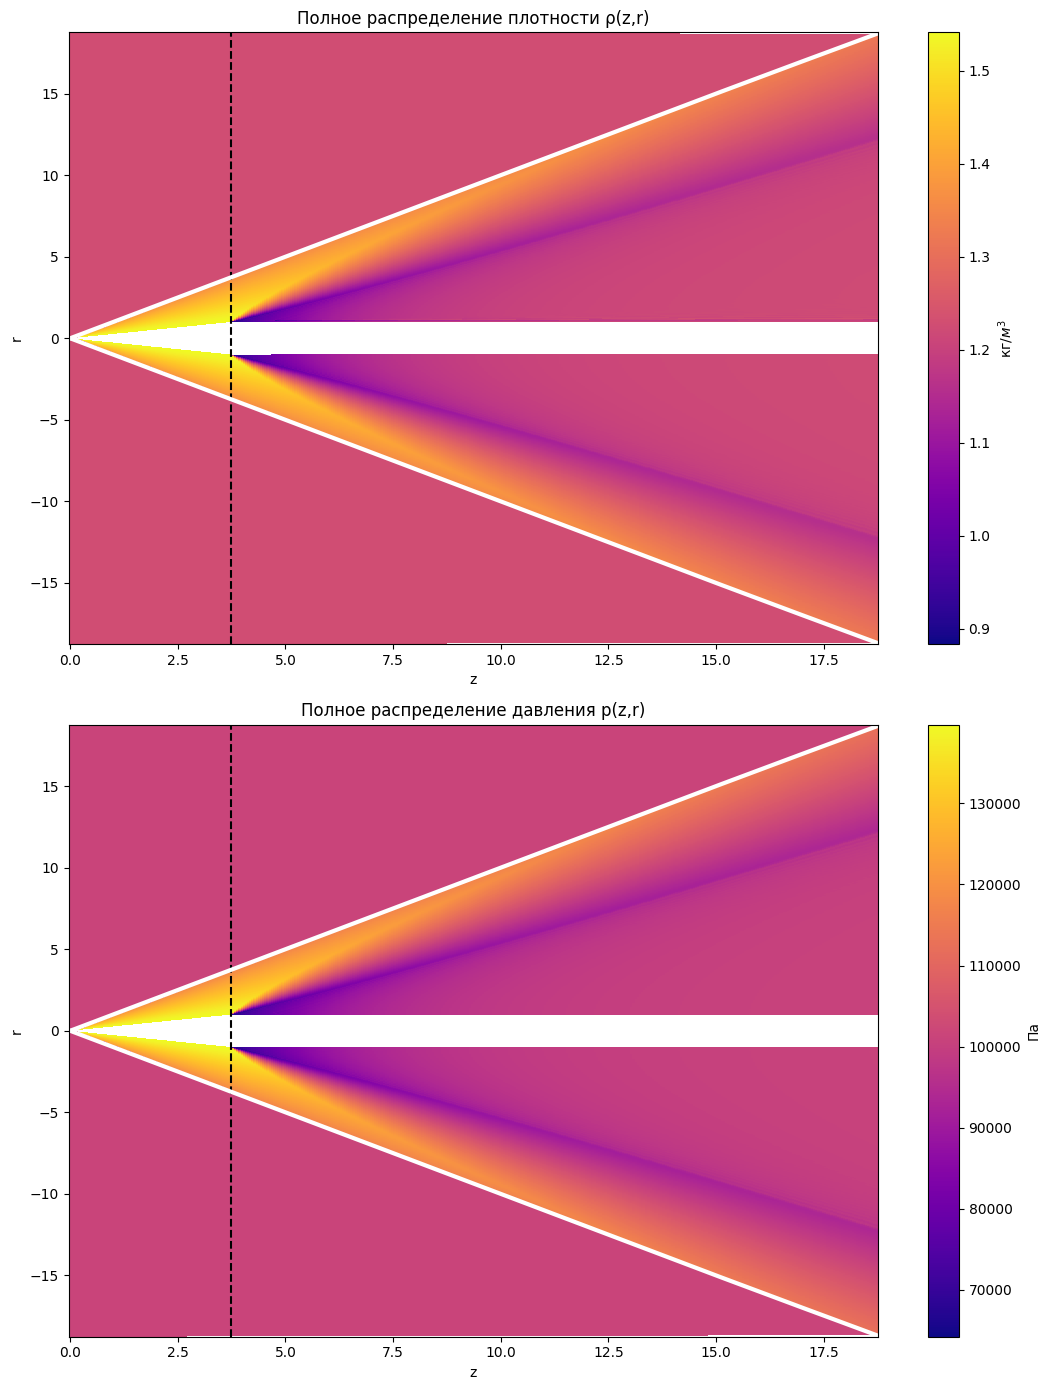

In [9]:
distribution_plot_subplots(
    ['rho', 'p'],
    figsize=(11,14),
    # output_name='pictures/parabolic_heat_rho_p.png'
)

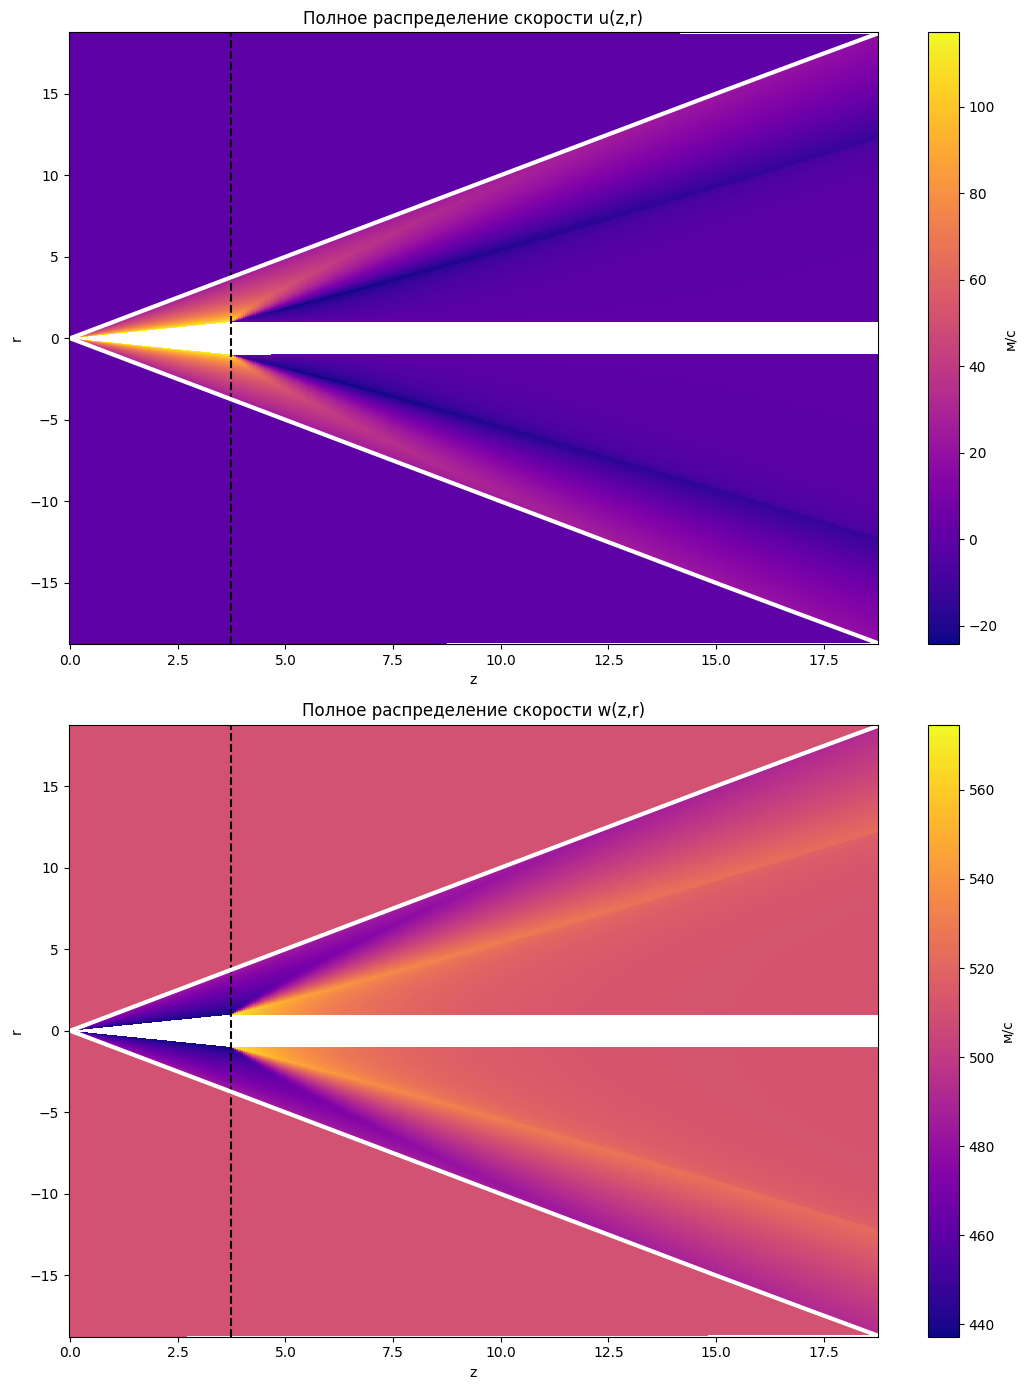

In [10]:
distribution_plot_subplots(
    ['u', 'w'],
    figsize=(11,14),
    # output_name='pictures/parabolic_heat_u_w.png'
)

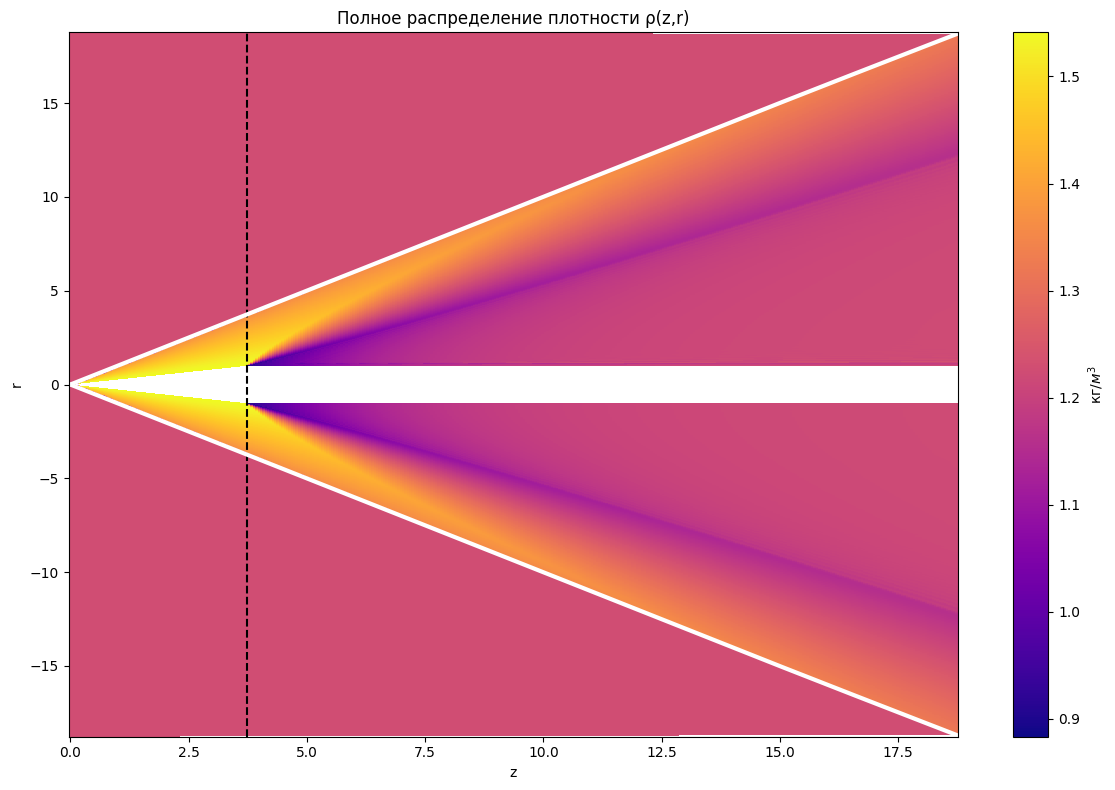

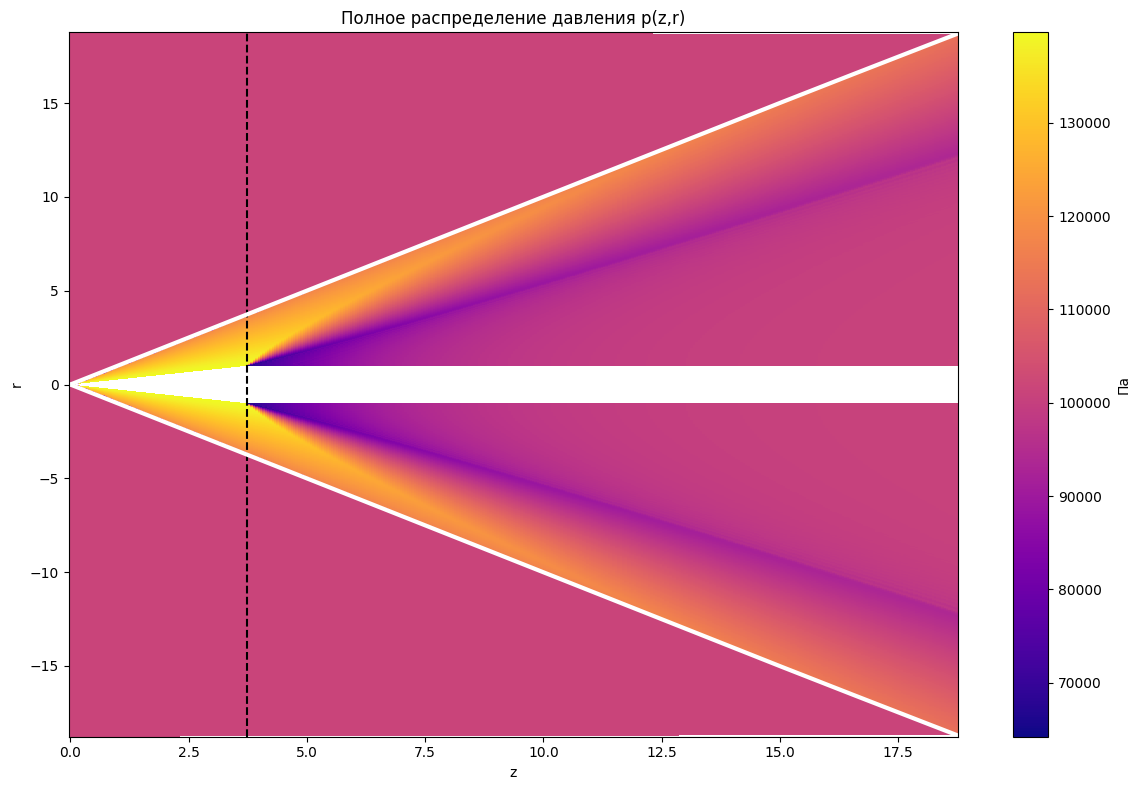

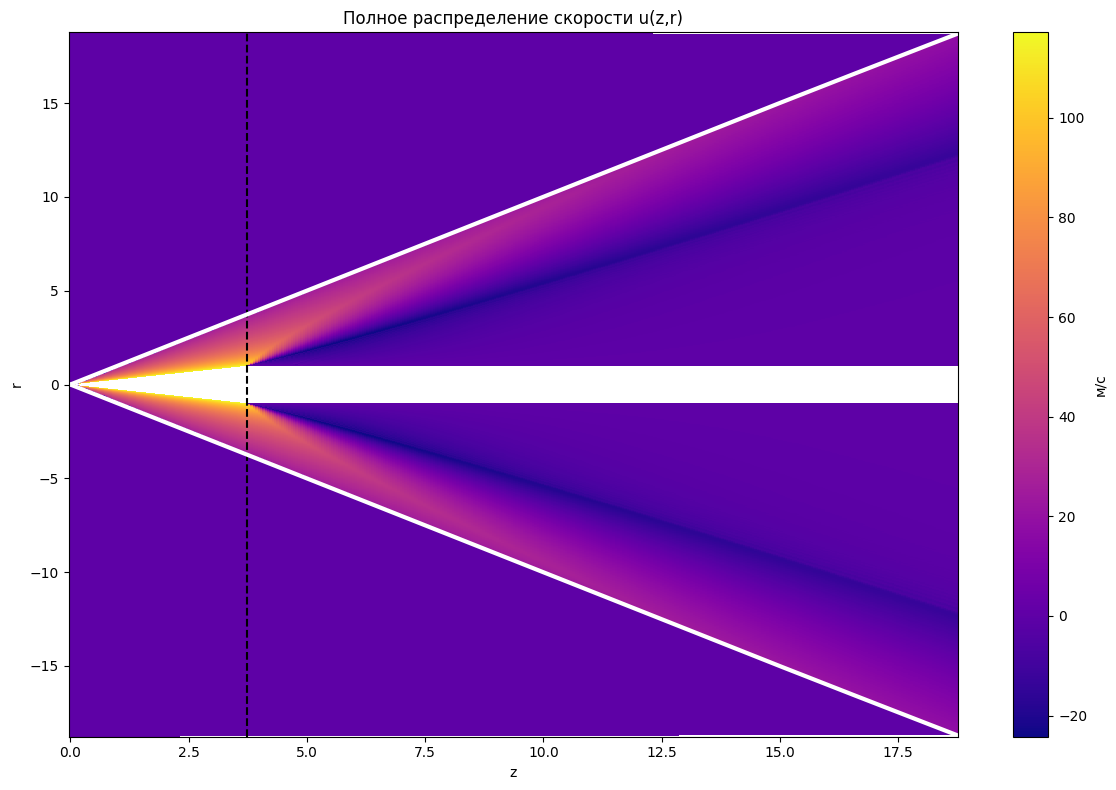

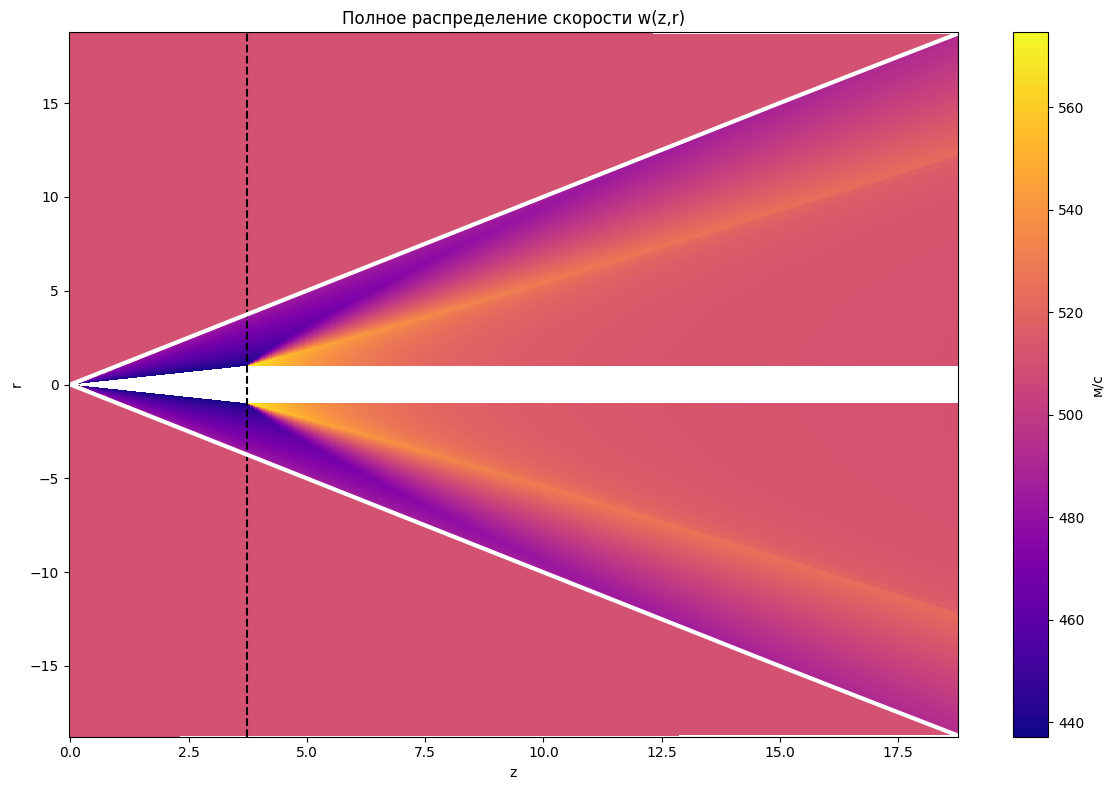

In [11]:
for func in ['rho', 'p', 'u', 'w']:
    distribution_plot_subplots([func], figsize=(12,8))

### Контур ударной волны

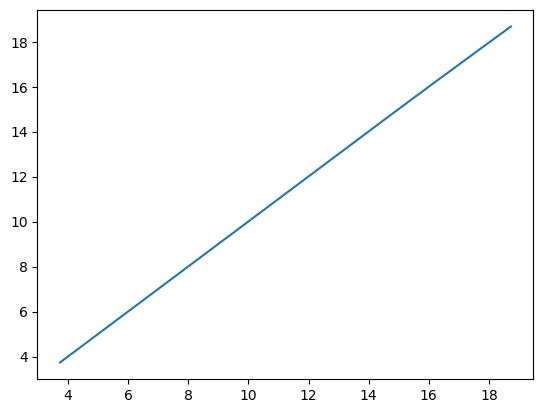

In [12]:
plt.plot(zs, rs[:,0])

### Отрисовка линий тока (с помощью функции тока сжимаемой жидкости psi)

In [13]:
def load_streamfunc(filename):
    zs, psi = [], []
    i = 0
    with open(filename) as f:
        for line in f:
            if i % 2 == 0:
                zs.append(float(line))
            else:
                psi.append(list(map(float, line.split())))
            i += 1
    return np.array(zs), np.array(psi)  # zs: (K,), psi: (K,N)

psi0 = np.loadtxt('psi0_out.txt')
psip = np.loadtxt('psi1_out.txt')

f_cone_dict = {
        'p': p_cone,
        'rho': rho_cone,
        'u': np.sin(phi_cone)*VR_cone + np.cos(phi_cone)*Vtheta_cone,
        'v': np.zeros_like(p_cone),
        'w': np.cos(phi_cone)*VR_cone - np.sin(phi_cone)*Vtheta_cone
}

z_cone = np.tile(np.linspace(0, z0, 100), (phi_cone.shape[0], 1)).T

r_cone = np.outer(np.linspace(0, z0, 100), np.tan(phi_cone))

rho_cone_tile = np.tile(f_cone_dict['rho'], (100, 1))
w_cone_tile = np.tile(f_cone_dict['w'], (100, 1))

dr_cone = np.hstack((np.zeros((100, 1)), np.diff(r_cone, axis=1)))

psi_cone = np.cumsum(rho_cone_tile * w_cone_tile * r_cone * dr_cone, axis=1)

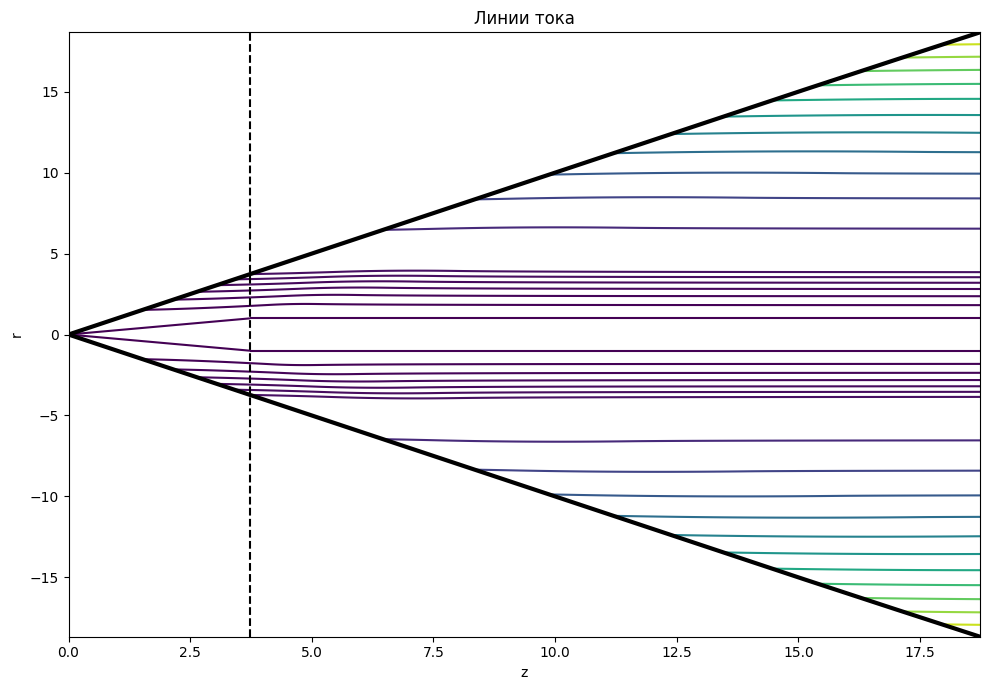

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))
levels_cone = np.linspace(psi_cone.min(), psi_cone.max(), 7)
levels_0 = np.unique(
    np.clip(
        np.hstack((levels_cone, np.linspace(psi_cone.max(), psi0.max(), 13))),
        a_min=psi0.min(),
        a_max=psi0.max(),
    )
)
levels_1 = np.unique(
    np.clip(
        np.hstack((levels_cone, np.linspace(psi_cone.max(), psip.max(), 13))),
        a_min=psip.min(),
        a_max=psip.max(),
    )
)
cs0 = ax.contour(np.tile(zs, (N, 1)).T, r_phys, psi0, levels=levels_0, linestyles="-")
csp = ax.contour(np.tile(zs, (N, 1)).T, -r_phys, psip, levels=levels_1, linestyles="-")
cs_cone_0 = ax.contour(z_cone, r_cone, psi_cone, levels=levels_cone, cmap=cs0.cmap, norm=cs0.norm, linestyles="-")
cs_cone_p = ax.contour(z_cone, -r_cone, psi_cone, levels=levels_cone, cmap=csp.cmap, norm=csp.norm, linestyles="-")
# ax.clabel(cs0, inline=True, fontsize=8)
# ax.clabel(csp, inline=True, fontsize=8)
ax.set_xlabel("z")
ax.set_ylabel("r")
plt.plot(
    np.hstack((np.linspace(0, z0), zs)),
    np.hstack((np.tan(phi_cone[-1]) * np.linspace(0, z0), rs[:, 0])),
    linewidth=3,
    color="black",
)
plt.plot(
    np.hstack((np.linspace(0, z0), zs)),
    np.hstack((-np.tan(phi_cone[-1]) * np.linspace(0, z0), -rs[:, -1])),
    linewidth=3,
    color="black",
)

ax.axvline(x=z0, linestyle="--", color="k")
plt.title('Линии тока')
plt.tight_layout()
# plt.savefig('pictures/parabolic_heat_streamlines.png')
plt.show()

### Разность давлений на theta = 0 и на theta = pi

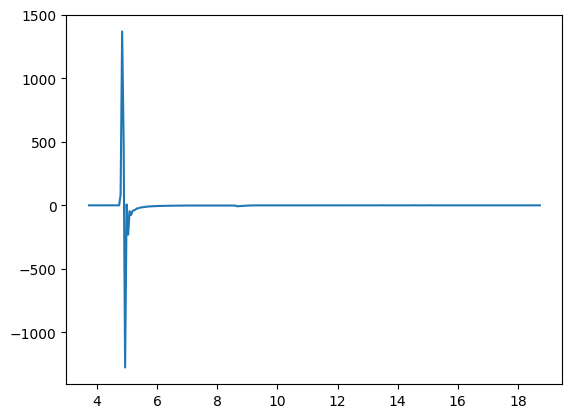

In [15]:
plt.plot(zs, p[:, 0, 0] - p[:, 0, -1])

### Зависимость подъемной силы от расположения источника (по z_q)

In [16]:
Fy_heat = np.loadtxt('Fy_out_heat.txt')
Mz_heat = np.loadtxt('Mz_out_heat.txt')
z_q_array = np.array([
    1.     , 1.01017, 1.02045, 1.03006, 1.04059, 1.05043, 1.06038,
    1.07045, 1.08064, 1.09009, 1.10051, 1.11073, 1.12067, 1.13084,
    1.14065, 1.15077, 1.16008, 1.17043, 1.1809 , 1.19052, 1.20025,
    1.21009, 1.22003, 1.23008, 1.24024, 1.25052, 1.26091, 1.27036,
    1.28097, 1.29062, 1.30038, 1.31023, 1.32018, 1.33024, 1.34041,
    1.35068, 1.36105, 1.37037, 1.38096, 1.39046, 1.40005, 1.41096,
    1.42075, 1.43063, 1.44061, 1.45068, 1.46085, 1.47112, 1.48019,
    1.49065, 1.50121, 1.51054, 1.52129, 1.53079, 1.54037, 1.55004,
    1.56118, 1.57103, 1.58096, 1.59097, 1.60108, 1.61126, 1.62007,
    1.63041, 1.64084, 1.65135, 1.66042, 1.67105, 1.68019, 1.6909 ,
    1.70011, 1.71088, 1.72017, 1.73107, 1.7405 , 1.75158, 1.76115,
    1.7708 , 1.78052, 1.79032, 1.80019, 1.81014, 1.82017, 1.83028,
    1.84046, 1.85073, 1.86108, 1.8715 , 1.88026, 1.89084, 1.9015 ,
    1.91046, 1.92128, 1.93036, 1.94135, 1.95056, 1.96171, 1.97107,
    1.98049, 1.99188, 2.00144
])

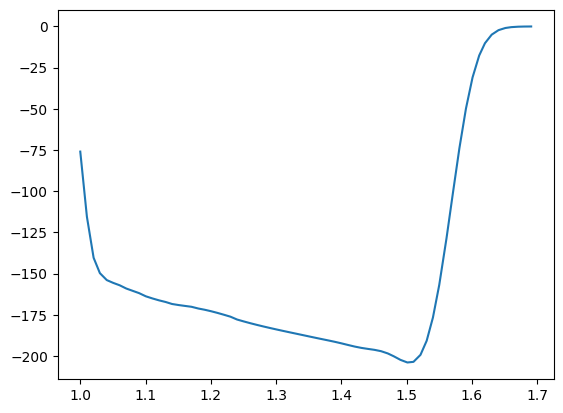

In [17]:
plt.plot(z_q_array[:Fy_heat.shape[0]], Fy_heat)

In [18]:
def plot_and_save(ax,
                  x: np.ndarray,
                  y: np.ndarray,
                  filename: str,
                  title: str = "Заголовок графика",
                  xlabel: str = "Ось X",
                  ylabel: str = "Ось Y",
                  figsize: tuple = (8, 6),
                  dpi: int = 100,
                  grid_kwargs: dict = None,
                  major_tick_params: dict = None,
                  minor_tick_params: dict = None):
    """
    Рисует график y = f(x) и сохраняет его в файл.

    Параметры:
    ----------
    x : np.ndarray
        Массив значений по оси X.
    y : np.ndarray
        Массив значений по оси Y (той же длины, что и x).
    filename : str
        Путь к выходному файлу (например, 'plot.png' или 'plot.pdf').
    title : str
        Заголовок графика.
    xlabel : str
        Подпись оси X.
    ylabel : str
        Подпись оси Y.
    figsize : tuple
        Размер рисунка в дюймах (ширина, высота).
    dpi : int
        Разрешение сохранённого изображения (точек на дюйм).
    grid_kwargs : dict
        Аргументы для `plt.grid(...)` основных линий сетки.
    major_tick_params : dict
        Аргументы для настройки основных рисок тиков, передаваемые в `ax.tick_params(axis='both', which='major', **major_tick_params)`.
    minor_tick_params : dict
        Аргументы для настройки вспомогательных рисок тиков, передаваемые в `ax.tick_params(axis='both', which='minor', **minor_tick_params)`.
    """

    # Задаём значения по умолчанию, если они не переданы
    if grid_kwargs is None:
        grid_kwargs = {
            'which': 'major',
            'linestyle': '-',
            'color': 'gray',
            'linewidth': 0.8,
            'alpha': 0.7
        }
    if major_tick_params is None:
        major_tick_params = {
            'direction': 'in',
            'length': 6,
            'width': 1
        }
    if minor_tick_params is None:
        minor_tick_params = {
            'direction': 'in',
            'length': 3,
            'width': 0.5
        }

    # Создаём фигуру и оси
    # fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    # Рисуем график
    ax.plot(x, y, label=ylabel)

    # Заголовок и подписи
    ax.set_title(title, fontsize=14, pad=10)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    # Основная сетка
    ax.grid(**grid_kwargs)

    # Включаем вспомогательные тики и сетку для них
    ax.minorticks_on()
    ax.grid(which='minor',
            linestyle='--',
            color='gray',
            linewidth=0.5,
            alpha=0.4)

    # Настройка параметров тиков
    ax.tick_params(axis='both', which='major', **major_tick_params)
    ax.tick_params(axis='both', which='minor', **minor_tick_params)

    # Добавляем легенду (если нужно)
    # ax.legend()

    # Подгонка компоновки и сохранение
    fig.tight_layout()
    # fig.savefig(filename)
    return ax
    # plt.show()
    # plt.close(fig)

In [21]:
def plot_on_ax(
    ax: plt.Axes,
    x: np.ndarray,
    y: np.ndarray,
    label: str = None,
    title: str = None,
    xlabel: str = None,
    ylabel: str = None,
    grid_kwargs: dict = None,
    major_tick_params: dict = None,
    minor_tick_params: dict = None,
):
    """
    Рисует одну кривую на заданной оси ax с полной настройкой оформления.

    Параметры:
    ----------
    ax : plt.Axes
        Ось для рисования.
    x, y : np.ndarray
        Данные.
    label : str, optional
        Метка для легенды.
    title : str, optional
        Заголовок графика оси.
    xlabel, ylabel : str, optional
        Подписи осей.
    grid_kwargs : dict, optional
        Настройки основной сетки.
    major_tick_params, minor_tick_params : dict, optional
        Параметры для настройки тиков.
    """
    # Default parameters
    if grid_kwargs is None:
        grid_kwargs = {
            'which': 'major',
            'linestyle': '-',
            'color': 'gray',
            'linewidth': 0.8,
            'alpha': 0.7,
        }
    if major_tick_params is None:
        major_tick_params = {'direction': 'in', 'length': 6, 'width': 1}
    if minor_tick_params is None:
        minor_tick_params = {'direction': 'in', 'length': 3, 'width': 0.5}

    # Plot
    ax.plot(x, y, label=label)

    # Labels and title
    if title:
        ax.set_title(title, fontsize=12, pad=8)
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=10)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=10)

    # Grid
    ax.grid(**grid_kwargs)
    ax.minorticks_on()
    ax.grid(which='minor', linestyle='--', linewidth=0.5, alpha=0.4)

    # Tick params
    ax.tick_params(axis='both', which='major', **major_tick_params)
    ax.tick_params(axis='both', which='minor', **minor_tick_params)

    # Legend
    if label:
        ax.legend()
    return ax


In [19]:
def plot_and_save_multiple(
    data_pairs: list,
    filename: str,
    titles: list = None,
    overall_title: str = None,
    nrows: int = None,
    ncols: int = None,
    figsize: tuple = (12, 8),
    dpi: int = 100,
    xlabel: str = None,
    ylabel: str = None,
    grid_kwargs: dict = None,
    major_tick_params: dict = None,
    minor_tick_params: dict = None,
):
    """
    Создаёт сетку подграфиков, рисует пары (x,y) и сохраняет в файл.

    Параметры:
    ----------
    data_pairs : list of tuple[np.ndarray, np.ndarray]
        Список кортежей с данными.
    filename : str
        Имя выходного файла.
    titles : list of str, optional
        Заголовки для каждого подграфика.
    overall_title : str, optional
        Общий заголовок.
    nrows, ncols : int, optional
        Число строк и столбцов. Авто-расчёт при None.
    figsize : tuple
        Размер фигуры.
    dpi : int
        Разрешение.
    xlabel, ylabel : str, optional
        Подписи осей для всех графиков.
    grid_kwargs, major_tick_params, minor_tick_params : dict, optional
        Параметры оформления.
    """
    num = len(data_pairs)
    # Default titles
    if titles is None:
        titles = [''] * num
    if len(titles) != num:
        raise ValueError("Количество заголовков должно совпадать с числом графиков")

    # Auto-calc grid
    if nrows is None and ncols is None:
        ncols = int(np.ceil(np.sqrt(num)))
        nrows = int(np.ceil(num / ncols))
    elif nrows is None:
        nrows = int(np.ceil(num / ncols))
    elif ncols is None:
        ncols = int(np.ceil(num / nrows))

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, dpi=dpi, squeeze=False)
    axes_flat = axes.flatten()

    for idx, ((x, y), ax, title) in enumerate(zip(data_pairs, axes_flat, titles)):
        plot_on_ax(
            ax, x, y,
            label=None,
            title=title,
            xlabel=xlabel,
            ylabel=ylabel,
            grid_kwargs=grid_kwargs,
            major_tick_params=major_tick_params,
            minor_tick_params=minor_tick_params,
        )

    # Remove empty axes
    for ax in axes_flat[num:]:
        fig.delaxes(ax)

    if overall_title:
        fig.suptitle(overall_title, fontsize=14, y=1.02)

    fig.tight_layout()
    fig.savefig(filename, bbox_inches='tight')
    plt.show()
    plt.close(fig)

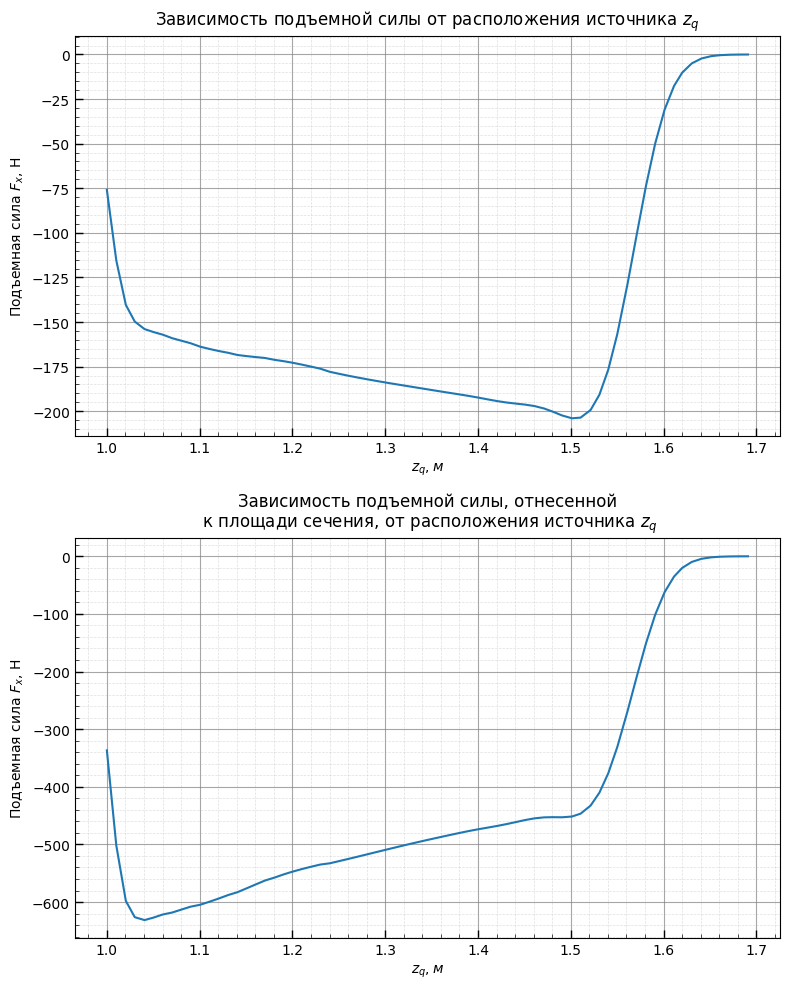

In [54]:
pairs = []
titles = []
z_q = z_q_array[:Fy_heat.shape[0]]
r_b_array = r_b(z_q)
S_b = np.pi * r_b(z_q)**2
pairs.append((z_q, Fy_heat))
pairs.append((z_q, Fy_heat / S_b))
titles = [
    r'Зависимость подъемной силы от расположения источника $z_q$',
    'Зависимость подъемной силы, отнесенной\n к площади ' + r'сечения, от расположения источника $z_q$',
]
plot_and_save_multiple(
    pairs,
    'pictures/for_article/Fx_by_heat_location.png',
    titles=titles,
    # overall_title='Несколько графиков',
    xlabel='$z_q, м$',
    ylabel='Подъемная сила $F_x$, Н',
    nrows=2,
    ncols=1,
    figsize=(8, 10)
)

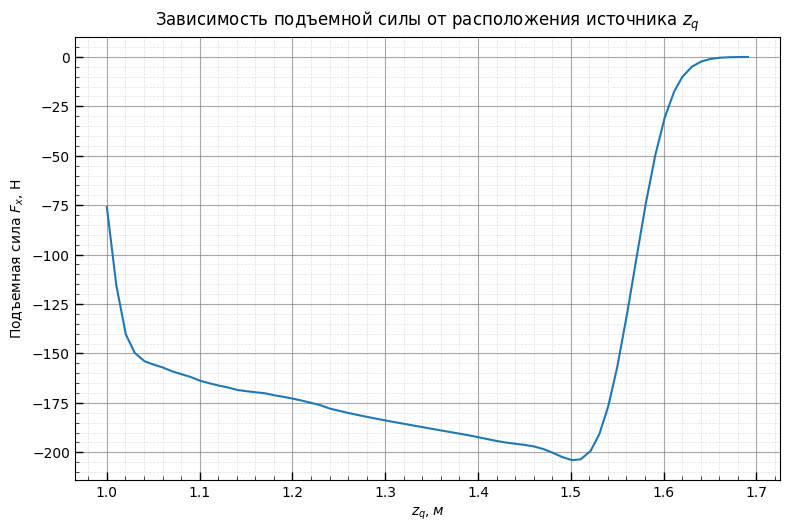

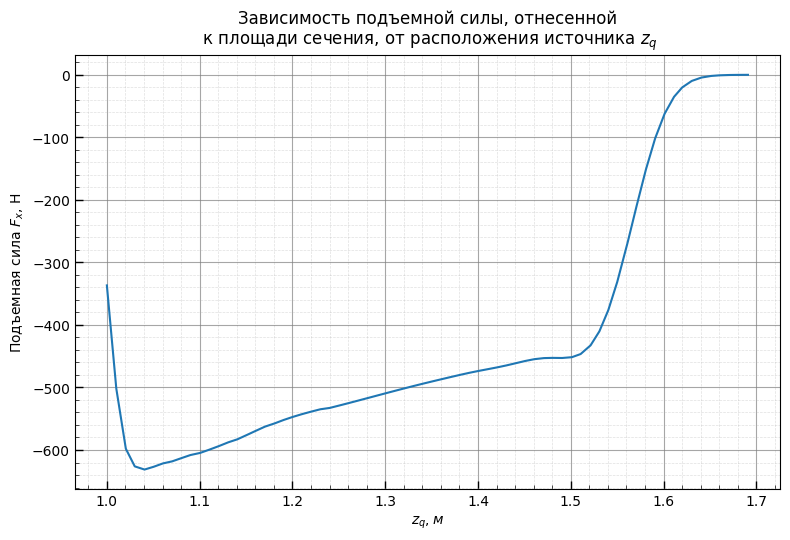

In [55]:
path = [
    'pictures/for_presentation/Fx_by_heat_location.png',
    'pictures/for_presentation/Fx_to_S_by_heat_location.png'
]
for i in range(2):
    plot_and_save_multiple(
        [pairs[i]],
        path[i],
        titles=[titles[i]],
        xlabel='$z_q, м$',
        ylabel='Подъемная сила $F_x$, Н',
        nrows=2,
        ncols=1,
        figsize=(8, 10)
    )

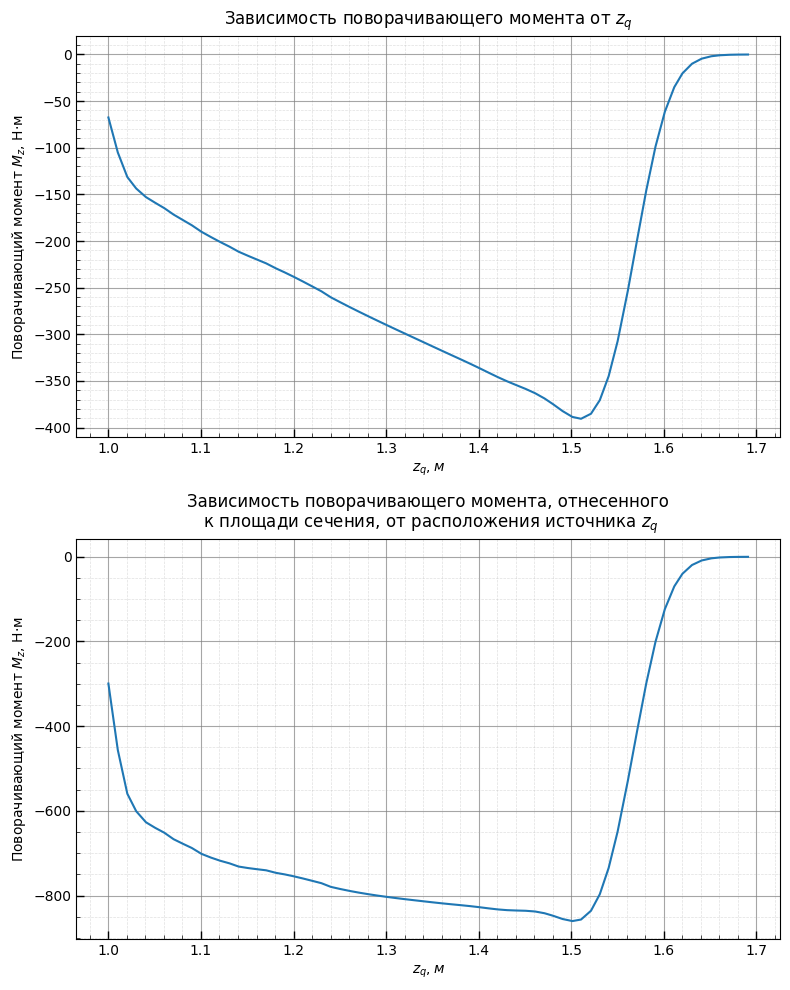

In [57]:
pairs = []
titles = []
pairs.append((z_q_array[:Fy_heat.shape[0]], Mz_heat))
pairs.append((z_q_array[:Fy_heat.shape[0]], Mz_heat / S_b))
titles = [
    r'Зависимость поворачивающего момента от $z_q$',
    'Зависимость поворачивающего момента, отнесенного\n к площади ' + r'сечения, от расположения источника $z_q$',
]
plot_and_save_multiple(
    pairs,
    'pictures/for_article/Mz_by_heat_location.png',
    titles=titles,
    # overall_title='Несколько графиков',
    xlabel='$z_q, м$',
    ylabel='Поворачивающий момент $M_z$, Н$\cdot$м',
    nrows=2,
    ncols=1,
    figsize=(8, 10)
)

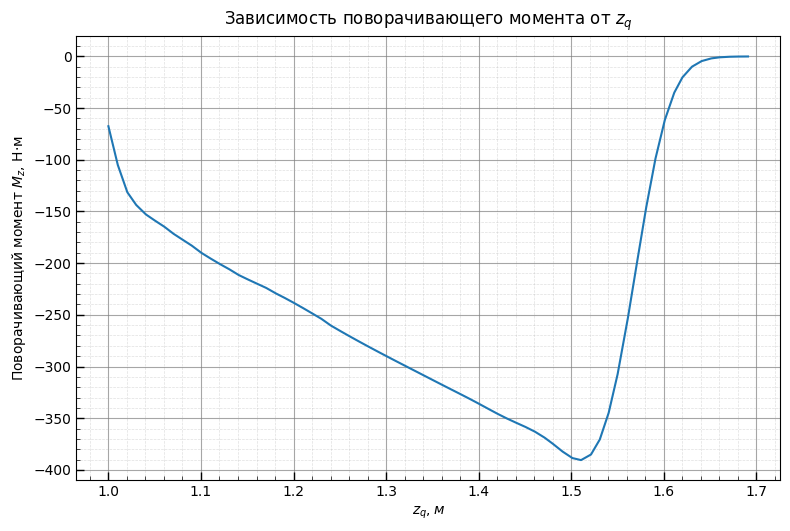

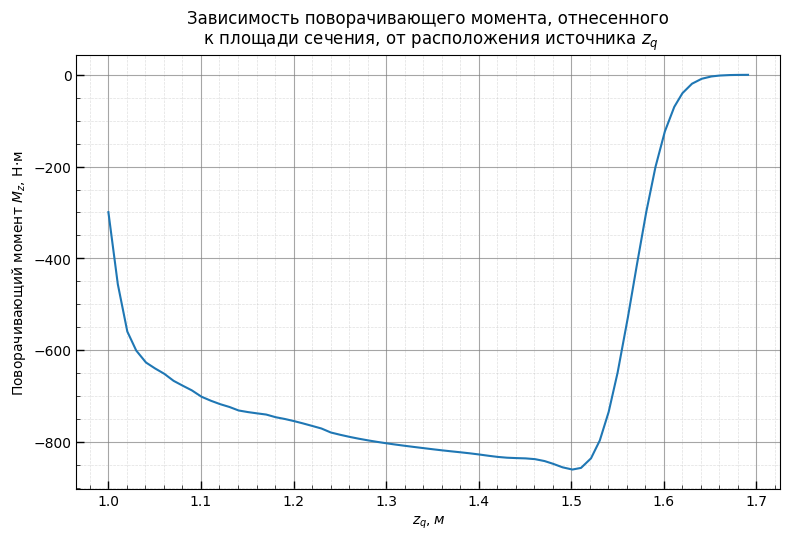

In [58]:
path = [
    'pictures/for_presentation/Mz_by_heat_location.png',
    'pictures/for_presentation/Mz_to_S_by_heat_location.png'
]
for i in range(2):
    plot_and_save_multiple(
        [pairs[i]],
        path[i],
        titles=[titles[i]],
        xlabel='$z_q, м$',
        ylabel='Поворачивающий момент $M_z$, Н$\cdot$м',
        nrows=2,
        ncols=1,
        figsize=(8, 10)
    )

### Отрисовка подъемной силы (интеграл давления от z0 до z -- функция от z)

In [44]:
ders_4course = np.loadtxt('derivative.txt')

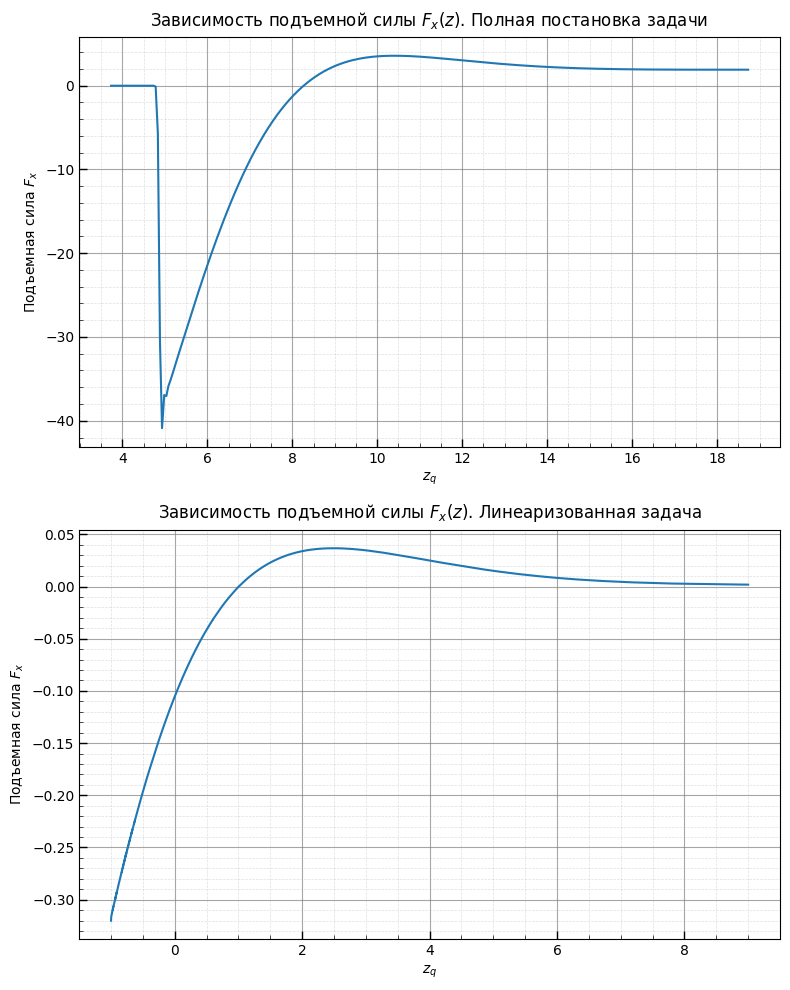

In [59]:
pairs = []
titles = []
pairs.append((zs, Fy))
pairs.append((ders_4course[:,0], -ders_4course[:,1]))
titles = [
    'Зависимость подъемной силы $F_x(z)$. Полная постановка задачи',
    'Зависимость подъемной силы $F_x(z)$. Линеаризованная задача',
]
plot_and_save_multiple(
    pairs,
    'pictures/for_article/4course_comparison.png',
    titles=titles,
    # overall_title='Несколько графиков',
    xlabel='$z_q$',
    ylabel='Подъемная сила $F_x$',
    nrows=2,
    ncols=1,
    figsize=(8, 10)
)

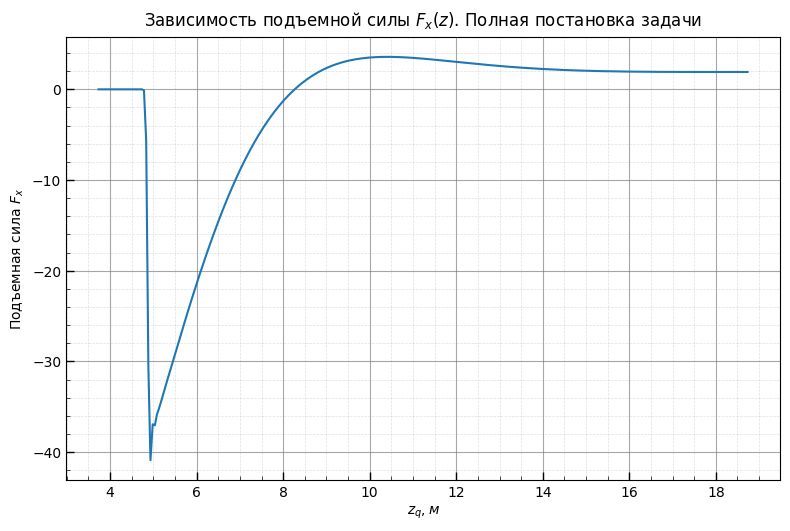

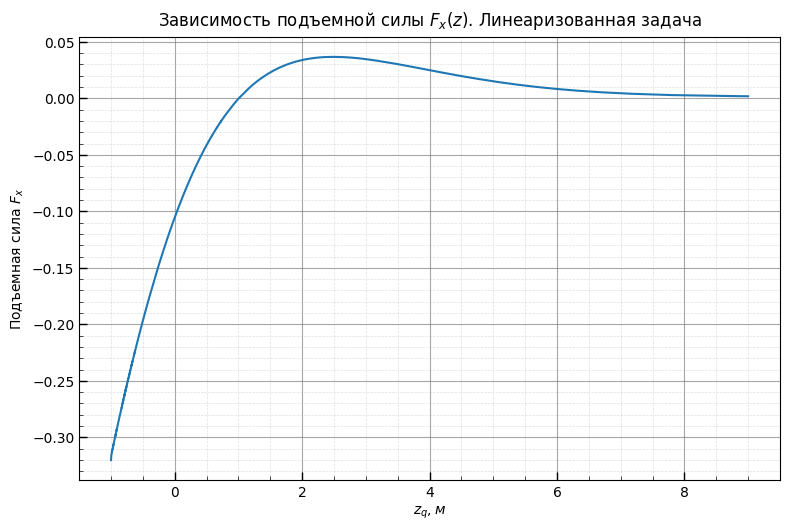

In [61]:
path = [
    'pictures/for_presentation/Fx_by_body_length.png',
    'pictures/for_presentation/Fx_analytic_by_body_length.png'
]
for i in range(2):
    plot_and_save_multiple(
        [pairs[i]],
        path[i],
        titles=[titles[i]],
        xlabel='$z_q, м$',
        ylabel='Подъемная сила $F_x$',
        nrows=2,
        ncols=1,
        figsize=(8, 10)
    )